# Projekt: Key-Stroke

Malte Eggers, Joel Enß

## Gliederung

1. Problemstellung
2. Datensatz erkunden
3. Datenvorverarbeitung

        3.1. Bereinigung
        3.2. Skalierung der Daten
        3.3. Aufteilung in Trainings-, Test- und Validierungsset
        3.4. Korrelation und Minimieren
4. Modelle trainieren

        4.1. SVM
        4.2. Log. Regression
        4.3. KNN
        4.4. Random Forest Classifier
        4.5. Neuronales Netz
5. Auswertung der Modelle
6. Modell optimieren
7. Evaluation des Modells
8. Diskussion


### 1. Problemstellung

Da heutzutage auf mobilen Endgeräten immer mehr sensible Daten gespeichert werden, ist es nötig, die Sicherheit dieser Geräte zu optimieren. Eine Möglichkeit dies umzusetzen, ist die biometrische Autentifikation mittels "Key-Stroke-Patterns". Dabei hat jeder Benutzer einen individuellen "Fingerabdruck", welcher aus bspw. dem Druck, der Fläche oder der Haltezeit der Tasten besteht.

### 2. Datensatz erkunden

In [2]:
# benutzte Python-Version: 3.12.8
import numpy as np  
import matplotlib.pyplot as plt
import pandas as pd 

with open("dataset.csv", "r+") as fobj:
    inhalt = fobj.read()
    inhalt = inhalt.replace(",", ".")
    fobj.seek(0)
    fobj.truncate(0)
    fobj.write(inhalt)

data = pd.read_csv('dataset.csv', delimiter=';', skiprows=3)

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2911 entries, 0 to 2910
Data columns (total 72 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Subject           2856 non-null   float64
 1   Hold .            2856 non-null   float64
 2   Hold t            2856 non-null   float64
 3   Hold i            2856 non-null   float64
 4   Hold e            2856 non-null   float64
 5   Hold Shift        2856 non-null   float64
 6   Hold 5            2856 non-null   float64
 7   Hold Shift.1      2856 non-null   float64
 8   Hold Caps         2856 non-null   float64
 9   Hold r            2856 non-null   float64
 10  Hold o            2856 non-null   float64
 11  Hold a            2856 non-null   float64
 12  Hold n            2856 non-null   float64
 13  Hold l            2856 non-null   float64
 14  Hold Enter        2856 non-null   float64
 15  DD ..t            2856 non-null   float64
 16  DD t.i            2856 non-null   float64


In [4]:
data.head()

Subject  Hold .  Hold t  Hold i  Hold e  Hold Shift  Hold 5  Hold Shift.1  \
0      1.0    89.0    92.0    64.0    85.0       123.0    82.0          70.0   
1      1.0    90.0    88.0    99.0    83.0       123.0   101.0          81.0   
2      1.0    87.0    90.0    83.0    65.0        79.0    73.0          96.0   
3      1.0    71.0    81.0    62.0    72.0        83.0    94.0          89.0   
4      1.0    89.0    72.0    82.0    82.0        62.0    89.0          68.0   

   Hold Caps  Hold r  ...  Size Caps    Size r    Size o    Size a    Size n  \
0      101.0    84.0  ...   0.225806  0.225806  0.322581  0.290323  0.225806   
1       94.0    88.0  ...   0.225806  0.225806  0.322581  0.322581  0.258065   
2       62.0    64.0  ...   0.225806  0.193548  0.290323  0.322581  0.225806   
3      104.0    73.0  ...   0.225806  0.225806  0.258065  0.290323  0.225806   
4       88.0    69.0  ...   0.290323  0.225806  0.322581  0.258065  0.225806   

     Size l  Size Enter          AvH          AvP          AvA  
0  0.354839    0.258065  88.07142857  0.190971438  0.288018425  
1  0.387097    0.322581  92.07142857  0.186514294   0.27419354  
2  0.258065    0.225806  83.57142857  0.186171434  0.271889393  
3  0.322581    0.322581  81.42857143  0.177942863  0.278801835  
4  0.290323    0.387097  77.42857143  0.163200007   0.28341013  

[5 rows x 72 columns]

Zur Erstellung unseres Datensatzes haben 56 Probanden ein neun Zeichen langes Passwort ("tie5Roanl") jeweils 51 mal eingegeben. Bei der Eingabe wurden Daten wie die Zeit zwischen den verschiedenen eingegebenen Zeichen, der auf den Bildschirm wirkende Druck oder auch die Fingerfläche aufgenommen. Insgesamt hat der Datensatz 71 Features.

### 3. Datenvorverarbeitung

#### 3.1. Bereinigung

Da die Probanden durch Leerzeilen getrennt sind, entfernen wir diese zuerst. Außerdem ersetzen wir alle Kommata durch Punkte, um so die Zahlenwerte direkt als Float verwenden zu können.

In [5]:
data = data.dropna(axis='rows')

data = data.replace(",",".")
data.head()

Subject  Hold .  Hold t  Hold i  Hold e  Hold Shift  Hold 5  Hold Shift.1  \
0      1.0    89.0    92.0    64.0    85.0       123.0    82.0          70.0   
1      1.0    90.0    88.0    99.0    83.0       123.0   101.0          81.0   
2      1.0    87.0    90.0    83.0    65.0        79.0    73.0          96.0   
3      1.0    71.0    81.0    62.0    72.0        83.0    94.0          89.0   
4      1.0    89.0    72.0    82.0    82.0        62.0    89.0          68.0   

   Hold Caps  Hold r  ...  Size Caps    Size r    Size o    Size a    Size n  \
0      101.0    84.0  ...   0.225806  0.225806  0.322581  0.290323  0.225806   
1       94.0    88.0  ...   0.225806  0.225806  0.322581  0.322581  0.258065   
2       62.0    64.0  ...   0.225806  0.193548  0.290323  0.322581  0.225806   
3      104.0    73.0  ...   0.225806  0.225806  0.258065  0.290323  0.225806   
4       88.0    69.0  ...   0.290323  0.225806  0.322581  0.258065  0.225806   

     Size l  Size Enter          AvH          AvP          AvA  
0  0.354839    0.258065  88.07142857  0.190971438  0.288018425  
1  0.387097    0.322581  92.07142857  0.186514294   0.27419354  
2  0.258065    0.225806  83.57142857  0.186171434  0.271889393  
3  0.322581    0.322581  81.42857143  0.177942863  0.278801835  
4  0.290323    0.387097  77.42857143  0.163200007   0.28341013  

[5 rows x 72 columns]

Nun teilen wir die Daten in y- und x-Daten auf. Dabei sind "Subject" die Labels, welche wir in y-data speichern.

In [6]:
y_data = data['Subject']
x_data = data.drop('Subject', axis='columns')

#### 3.2. Daten skalieren

Da die Wertebereiche der Daten teilweise sehr unterscheidlich sind, müssen diese erst skaliert werden. Hierzu wählen wir den StandardScaler.

In [7]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(x_data) 
x_scal = scaler.transform(x_data)

#### 3.3. Aufteilung in Trainings-, Test- und Validierungsset

Im beigefügten Paper wurden die Daten in Trainings-, Test- und Validationsset also 90%-5%-5% eingeteilt. 
Für den ersten Durchlauf aller Module wählen wir daher die gleich Aufteilung

In [8]:
from sklearn.model_selection import train_test_split

train_ratio = 0.9
validation_ratio = 0.05
test_ratio = 0.05

x_train, x_test, y_train, y_test = train_test_split(x_scal, y_data, test_size=1 - train_ratio, shuffle = True, random_state = 42)
#Testset jetzt 90% des gesamten Datensatzes

x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, shuffle = True, random_state = 42) 
#Validationset jetzt 50% des Testsets --> Testset 5% des gesamten Datensatzes

print(x_train.shape, x_val.shape, x_test.shape)

(2570, 71) (143, 71) (143, 71)


#### 3.4. Korrelation und Minimierung

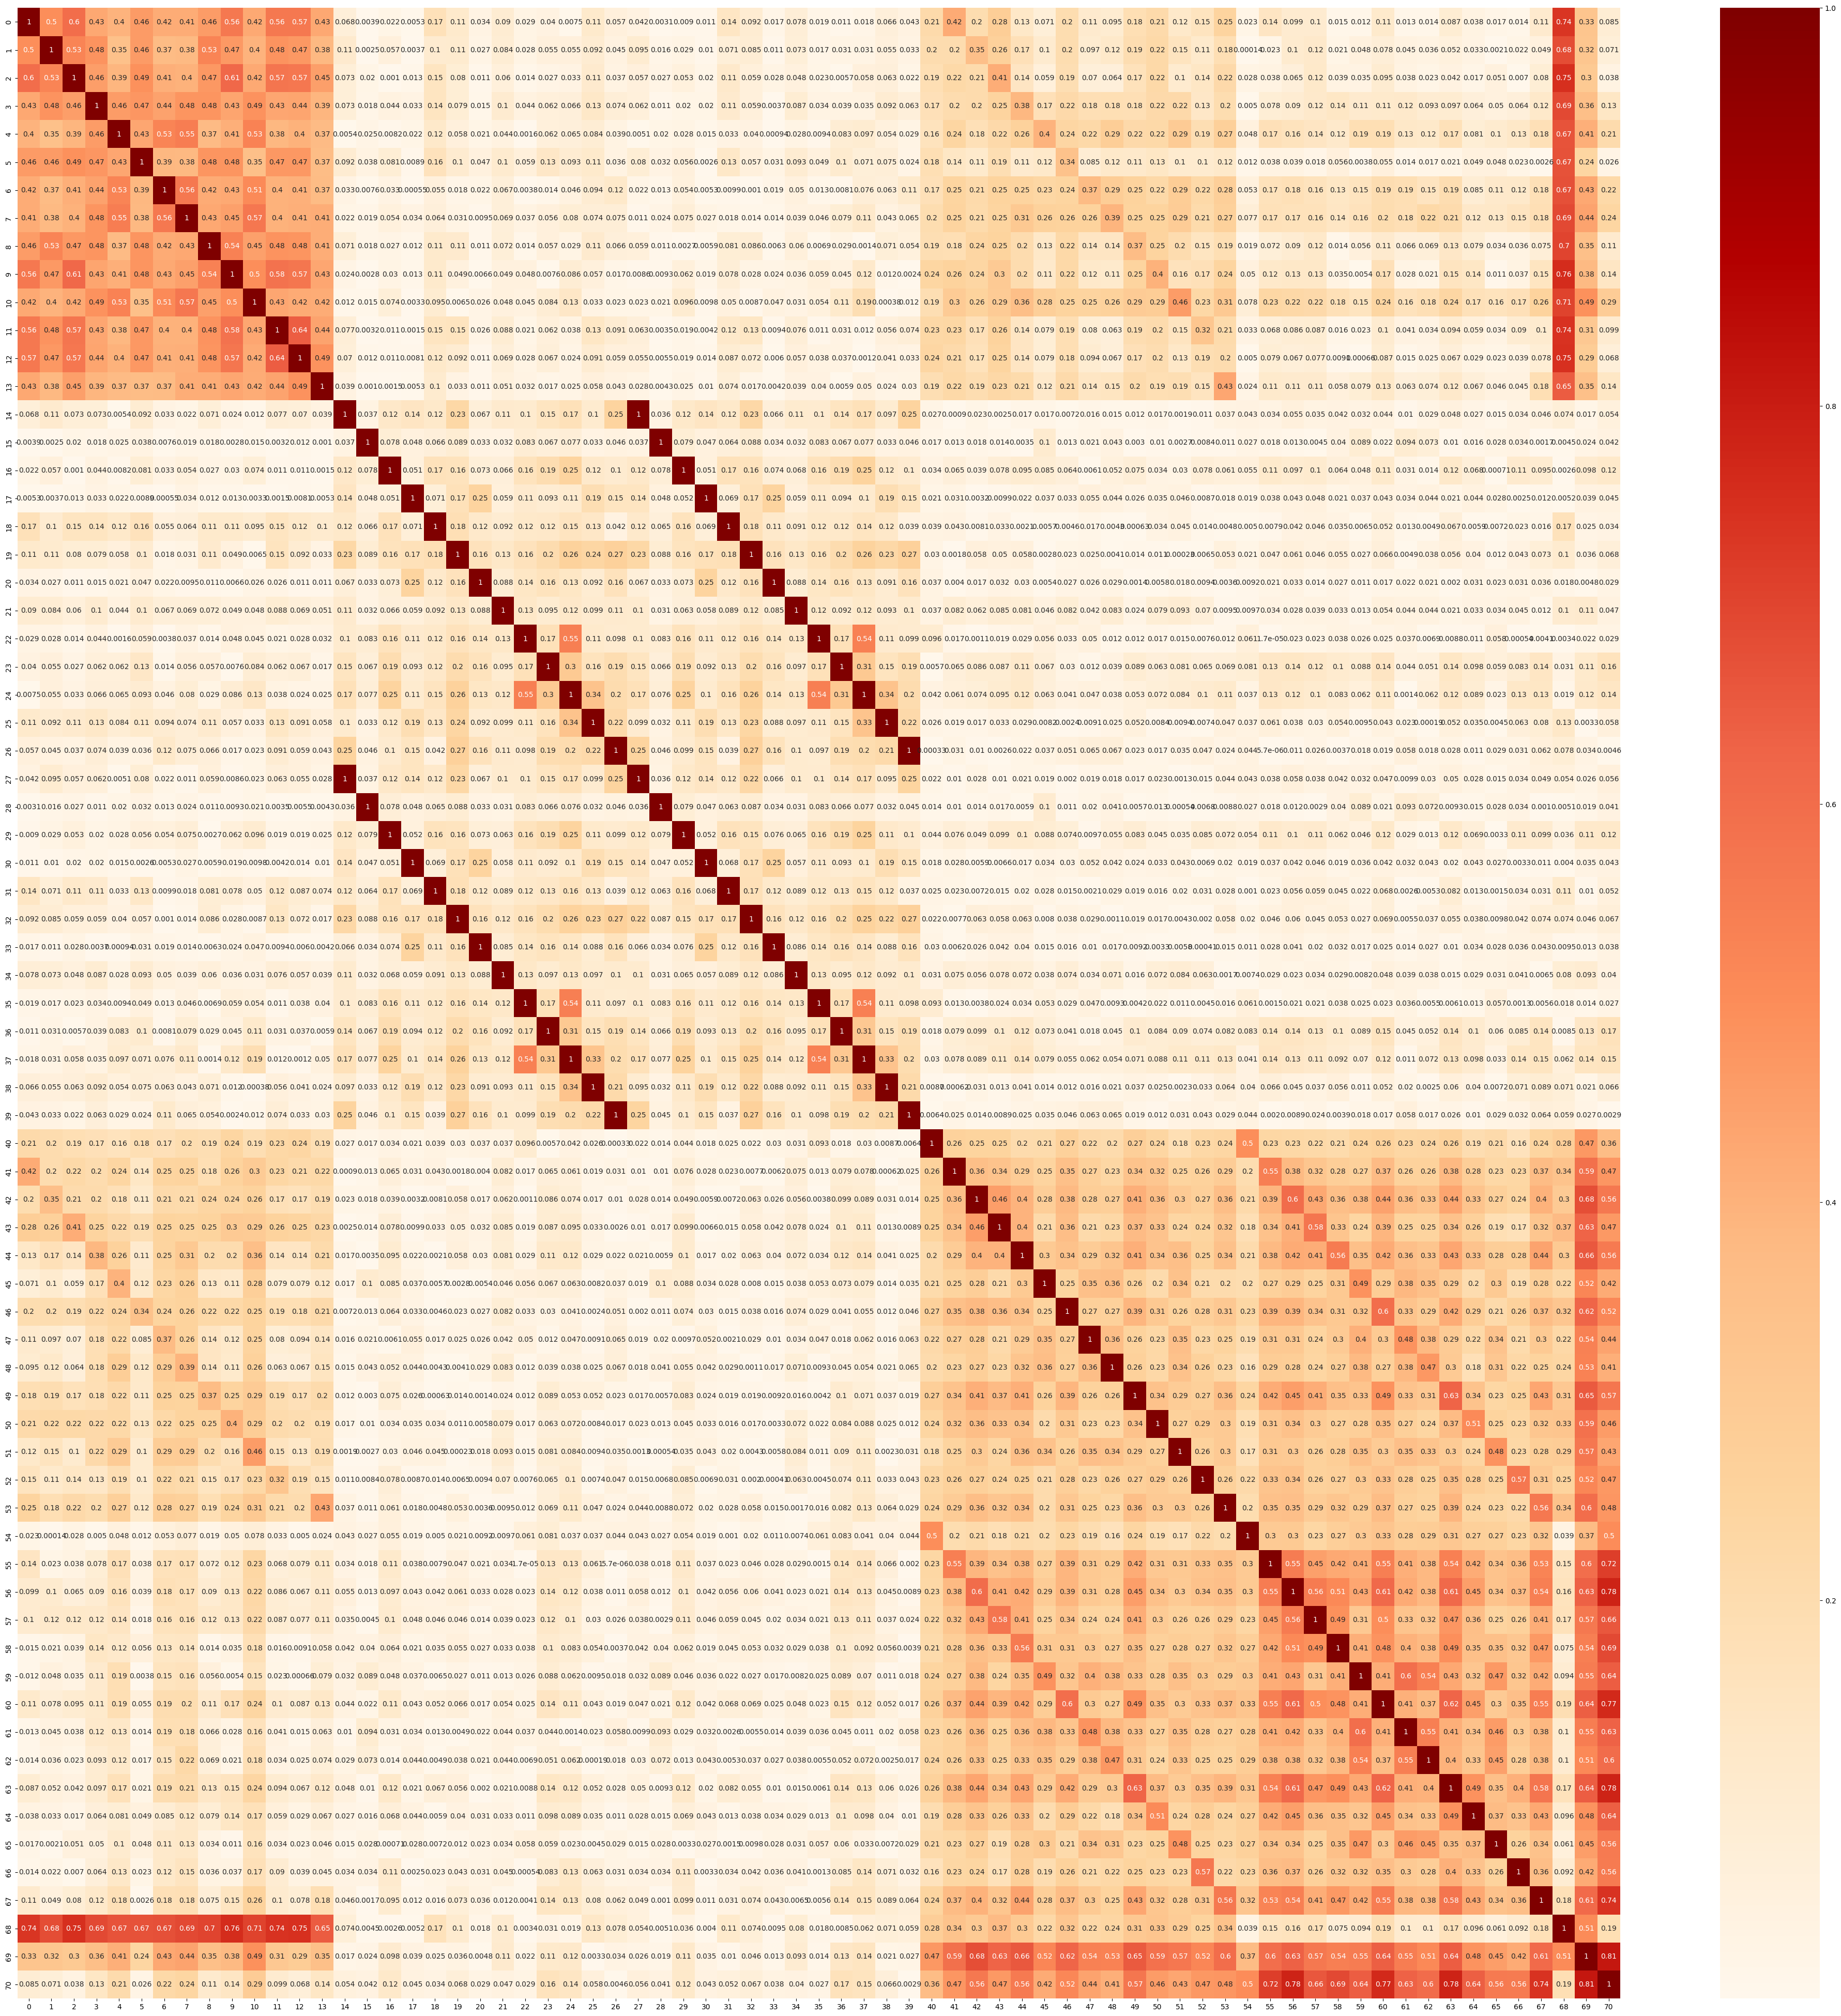

In [9]:
import seaborn as sn

df = pd.DataFrame.from_records(x_train)
df_cm = pd.DataFrame(df.corr(), index = [i for i in np.arange(0,71)], columns = [i for i in np.arange(0,71)])
plt.figure(figsize = (50,50))
sn.heatmap(abs(df_cm), annot = True, cmap = "OrRd")
plt.savefig("Korrelation_1")

Die Matrix zeigt eine deutliche Korrelation zwischen den Werten Down-Down (Index: 14-26) und Up-Down (Index: 27-39). Da die Werte Up-Down in Down-Down bereits enthalten sind, droppen wir diese.

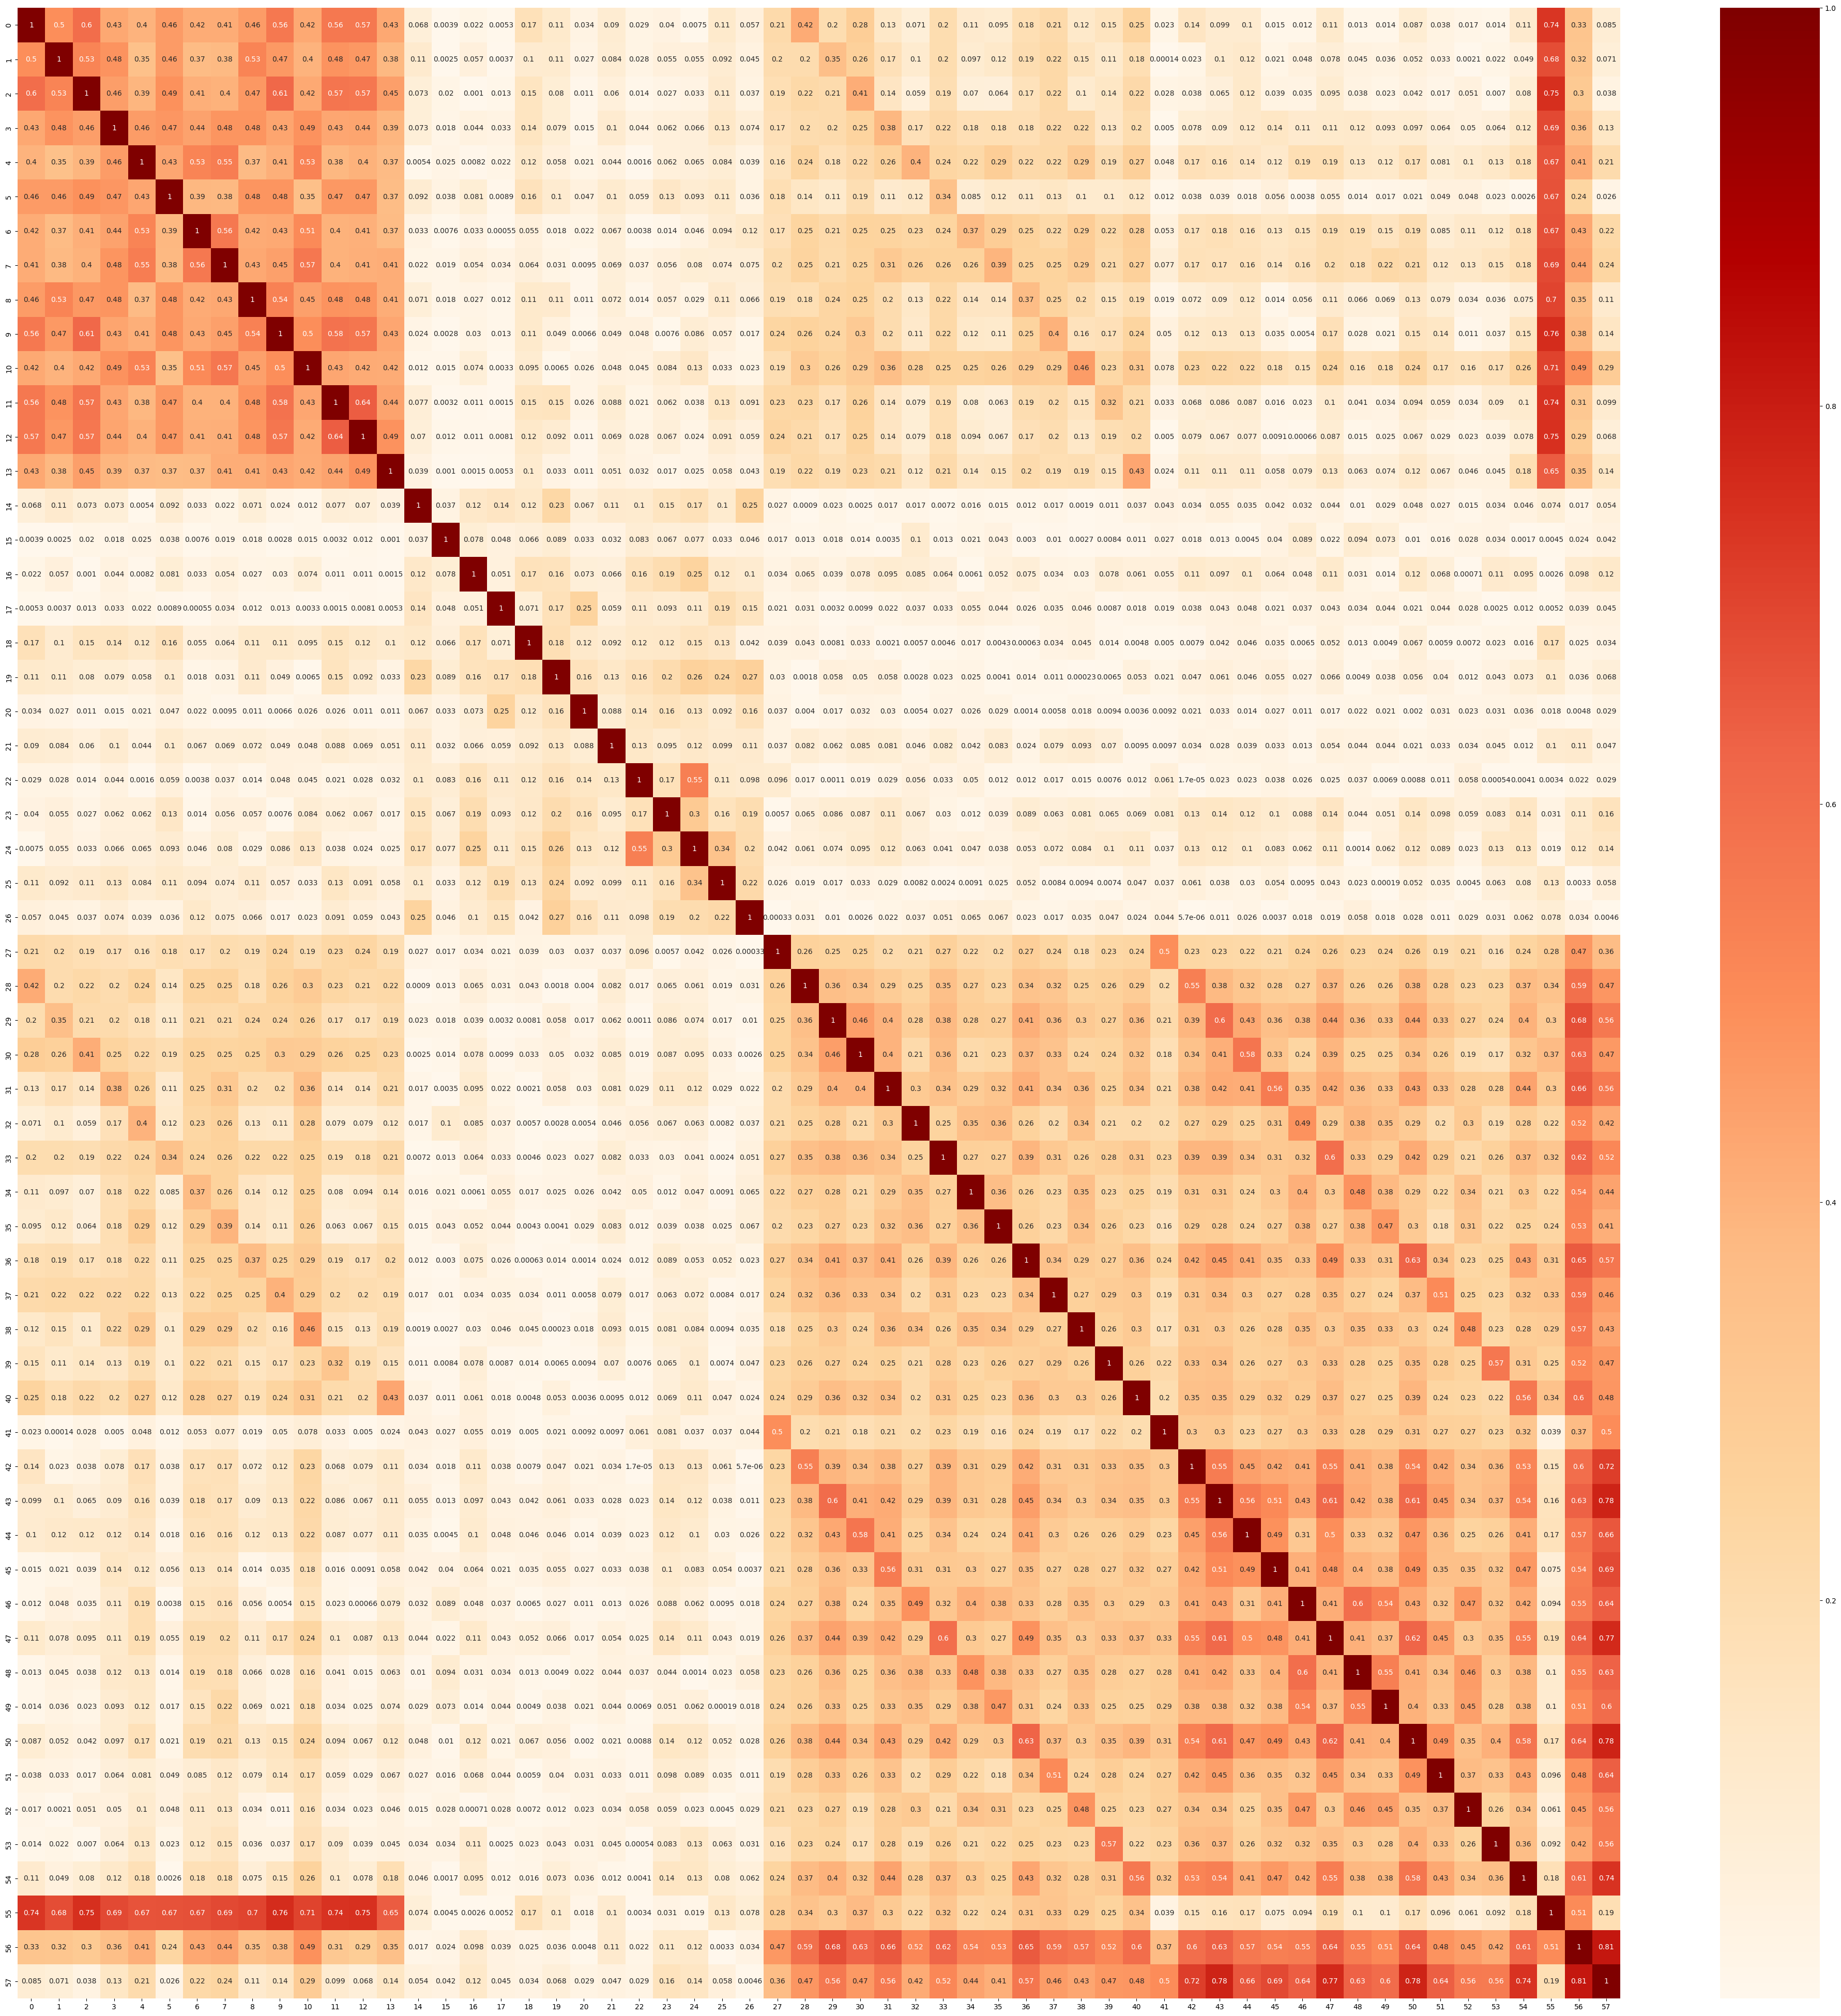

In [10]:
x_val = np.delete(x_val, [np.arange(27,40)],1)
x_test = np.delete(x_test, [np.arange(27,40)],1)
x_train = np.delete(x_train, [np.arange(27,40)],1)
df_2 = pd.DataFrame.from_records(x_train)

df_cm_2 = pd.DataFrame(df_2.corr(), index = [i for i in np.arange(0,58)], columns = [i for i in np.arange(0,58)])
plt.figure(figsize = (50,50))
sn.heatmap(abs(df_cm_2), annot = True, cmap = "OrRd")
plt.savefig("Korrelation_2")

## 4. Modelle trainieren

#### 4.1. SVM

In [11]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC

svc = SVC() #default kernel = "rbf", radial nichtlinear
cv_svc = cross_val_score(svc, x_train, y_train, scoring = "accuracy", cv = 5)

#### 4.2. Log. Regression

In [12]:
from sklearn.linear_model import LogisticRegression

log_reg = LogisticRegression(max_iter = 200)
cv_log_reg = cross_val_score(log_reg, x_train, y_train, scoring = "accuracy", cv = 5)

#### 4.3. KNN

In [13]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
cv_knn = cross_val_score(knn, x_train, y_train, scoring = "accuracy", cv = 5)

#### 4.4. Random Forest Classifier

In [14]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
cv_rf = cross_val_score(rf, x_train, y_train, scoring = "accuracy", cv = 5)

#### 4.5. Neuronales Netz

In [15]:
import tensorflow as tf
from tensorflow import keras

model = keras.Sequential([
    keras.Input(shape = (58, )),
    keras.layers.Dense(100, activation = "relu"),
    keras.layers.Dense(50, activation = "relu"),
    keras.layers.Dense(25, activation = "relu"),
    keras.layers.Dense(57, activation = "softmax")
    ])

model.compile(loss='sparse_categorical_crossentropy', optimizer="adam", metrics=['accuracy'])

    
history = model.fit(x_train,y_train, epochs=20, validation_data = (x_val, y_val))

test_loss, test_accuracy = model.evaluate(x_test, y_test)

Epoch 1/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.0468 - loss: 3.9409 - val_accuracy: 0.1259 - val_loss: 3.4894
Epoch 2/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.1903 - loss: 3.1901 - val_accuracy: 0.2448 - val_loss: 2.6424
Epoch 3/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3725 - loss: 2.2781 - val_accuracy: 0.3986 - val_loss: 1.9924
Epoch 4/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.5133 - loss: 1.6979 - val_accuracy: 0.5105 - val_loss: 1.5610
Epoch 5/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6049 - loss: 1.3352 - val_accuracy: 0.6643 - val_loss: 1.2239
Epoch 6/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6753 - loss: 1.0723 - val_accuracy: 0.6643 - val_loss: 1.0696
Epoch 7/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.7244 - loss: 0.9026 - val_accuracy: 0.6783 - val_loss: 0.9546
Epoch 8/20
81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7653 - loss: 0.7703 - val_accuracy: 0.6643 - val_loss:

## 5. Auswertung der Modelle

Die von uns trainierten Modelle hatten folgende Genauigkeiten:

In [16]:
print(f"SVM Genauigkeit: {cv_svc.mean():3f}, Standardabweichung: {cv_svc.std():3f}")
print(f"Log. Regression Genauigkeit: {cv_log_reg.mean():3f}, Standardabweichung: {cv_log_reg.std():3f}")
print(f"KNN Genauigkeit: {cv_knn.mean():3f}, Standardabweichung: {cv_knn.std():3f}")
print(f"Random Forest Genauigkeit: {cv_rf.mean():3f}, Standardabweichung: {cv_rf.std():3f}")
print(f"Neuronales Netz Genauigkeit: {test_accuracy:3f}, Standardabweichung: {test_loss:3f}")

SVM Genauigkeit: 0.791051, Standardabweichung: 0.009579
Log. Regression Genauigkeit: 0.771595, Standardabweichung: 0.014222
KNN Genauigkeit: 0.559144, Standardabweichung: 0.017899
Random Forest Genauigkeit: 0.923735, Standardabweichung: 0.008291
Neuronales Netz Genauigkeit: 0.713287, Standardabweichung: 0.891263


Wie man sieht, hat der KNN-Algorithmus mit ca. 56% mit Abstand die geringste Genauigkeit. Sowohl SVM und Log. Regression als auch das neuronale Netz haben eine Genauigkeit um die 75-80%. Der Random Forest Classifier hat mit ca. 93% die höchste Genauigkeit, weshalb wir uns auch entschieden haben, dieses Modell im Folgenden zu optimieren.

## 6. Modell optimieren

Im Folgenden werden wir die besten Parameter mittels der Klasse RandomizedSearchCV herausfinden. Dazu verwenden wir 5 Faltungen für 300 Kandidaten, also werden insgesamt 1500 Fits durchgeführt.

In [18]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score


rf = RandomForestClassifier()
param_random_rf = {
    'n_estimators': np.arange(50, 300, 1),
    'max_depth': np.arange(5, 20, 1),
}
random_search_rf = RandomizedSearchCV(estimator=rf, param_distributions=param_random_rf, n_iter=300, cv=5, verbose = 1, return_train_score=True)


random_search_rf.fit(x_train, y_train)
best_rf = random_search_rf.best_estimator_

print(f"Beste Parameter nach RandomSearch: {best_rf}")

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
Beste Parameter nach RandomSearch: RandomForestClassifier(max_depth=np.int64(15), n_estimators=np.int64(273))


Die besten Parameter für den RandomForest sind nach unserer Suche mit RandomizedSearchCV "n_estimators" = 273 und für "max_depth" = 15. Die Parameter "min_samples_split" und "min_samples_leaf" haben wir außenvorgelassen, da diese nicht so einen starken Einfluss auf die Genauigkeit des Modells haben und wir so dann die Trainingszeit reduzieren konnten. Der RandomForest mit den von uns gefundenen besten Parametern trainieren und evaluieren wir nun im Folgenden.

## 7. Evaluation des Modells

Nun evaluieren wir die Performance unseres Modells auf dem Testset mittels der Genauigkeit aber auch einer Konfusionsmatrix.

In [19]:
from sklearn.metrics import accuracy_score, confusion_matrix

y_pred = best_rf.predict(x_test)
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Genauigkeit des Random Forests auf dem Testset: {test_accuracy}")

Genauigkeit des Random Forests auf dem Testset: 0.965034965034965


C:\Users\Malte Eggers\AppData\Local\Temp\ipykernel_20220\1598858600.py:3: RuntimeWarning: invalid value encountered in divide
  cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


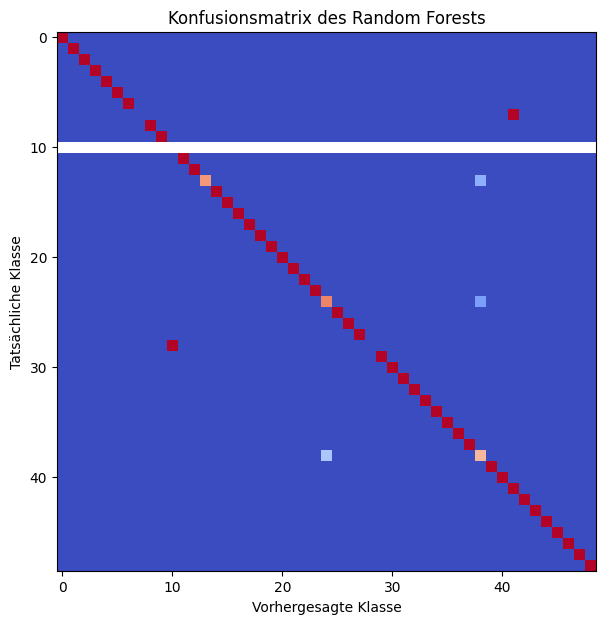

In [28]:
plt.figure(figsize = (10,7))
cm = confusion_matrix(y_test, y_pred)
cm_norm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
plt.imshow(cm_norm, cmap = "coolwarm")
plt.xlabel("Vorhergesagte Klasse")
plt.ylabel("Tatsächliche Klasse")
plt.title("Konfusionsmatrix des Random Forests")
plt.savefig("Konfusionsmatrix_RandomForest")
plt.show()

In [21]:
from sklearn.metrics import classification_report
class_report = classification_report(y_test, y_pred)
print(class_report)

              precision    recall  f1-score   support

         2.0       1.00      1.00      1.00         5
         3.0       1.00      1.00      1.00         2
         4.0       1.00      1.00      1.00         3
         5.0       1.00      1.00      1.00         1
         7.0       1.00      1.00      1.00         3
         8.0       1.00      1.00      1.00         2
         9.0       1.00      1.00      1.00         6
        10.0       0.00      0.00      0.00         1
        11.0       1.00      1.00      1.00         4
        12.0       1.00      1.00      1.00         3
        13.0       0.00      0.00      0.00         0
        14.0       1.00      1.00      1.00         4
        15.0       1.00      1.00      1.00         1
        16.0       1.00      0.75      0.86         4
        18.0       1.00      1.00      1.00         1
        19.0       1.00      1.00      1.00         3
        20.0       1.00      1.00      1.00         2
        21.0       1.00    

C:\Users\Malte Eggers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Malte Eggers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\Malte Eggers\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\metrics\